In [1]:
import plotly.express as px
import pandas as pd
import tinkoffpy as tf
import plotly.graph_objects as go
from datetime import datetime, timedelta, date
import datetime
import plotly.figure_factory as ff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

tf.auth_by_credentials(username='r.yunisov', password='Htyfn2002')


/Users/r.yunisov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = tf.gp_to_df("""
WITH cte AS (SELECT integration_id,
                    crm_income_dt,
                    DATE_TRUNC('month', crm_income_dt)::DATE AS crm_income_dt_month,
                    DATE_TRUNC('week', crm_income_dt)::DATE  AS crm_income_dt_week,
                    decision_dt,
                    utilization_dt,
--                     CASE
--                         WHEN decision_dt - crm_income_dt <= 31 AND utilization_dt - crm_income_dt <= 31
--                             THEN 'within 31 days'
--                         ELSE 'over 31 day'
--                         END                                     status,
                    CASE
                        WHEN decision_dt IS NULL THEN 0
                        WHEN decision_dt IS NOT NULL AND application_status_cd = 'UTV' AND
                             decision_dt - crm_income_dt <= 31 THEN 1
                        ELSE 0
                        END                                     status_open_rko,
                    CASE
                        WHEN utilization_dt IS NULL THEN 0
                        WHEN utilization_dt IS NOT NULL AND utilization_dt - crm_income_dt <= 31 THEN 1
                        ELSE 0
                        END                                     status_util_rko
             FROM prod_v_smemart.sme_application_scs
             WHERE crm_income_dt > '2023-01-01')
SELECT crm_income_dt,
       integration_id,
       utilization_dt - crm_income_dt AS diff_day
--        crm_income_dt_month,
--        SUM(status_open_rko)                                                           AS rko_open,
--        SUM(status_util_rko)                                                           AS rko_util,
--        COUNT(integration_id)                                                          AS total_qty,
--        ROUND(SUM(status_open_rko)::NUMERIC / COUNT(integration_id)::NUMERIC * 100, 2) AS cr_to_open,
--        ROUND(SUM(status_util_rko)::NUMERIC / COUNT(integration_id)::NUMERIC * 100, 2) AS cr_to_util_from_total,
--        ROUND(SUM(status_util_rko)::NUMERIC / SUM(status_open_rko)::NUMERIC * 100, 2)  AS cr_to_util_from_open
FROM cte
-- GROUP BY crm_income_dt_month
""", gp_service='sme')

2023-08-03 15:48:04 - WARNING - Library version is outdated, you have: 1.0.44
actual version: 1.0.47, please, update library.
2023-08-03 15:51:46 - INFO - Query executed successfully. Result saved to DataFrame.


Вычисляем окно конверсии, смотрим разницу в датах и рисуем распределение, чтобы сказать, сколько времени после окончания теста нужно на дозревание (За все время, все каналы)

/var/folders/3g/twm5z59x18s28jmjj3c3ghfm0000gq/T/ipykernel_26532/3871191998.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.diff_day.dropna())


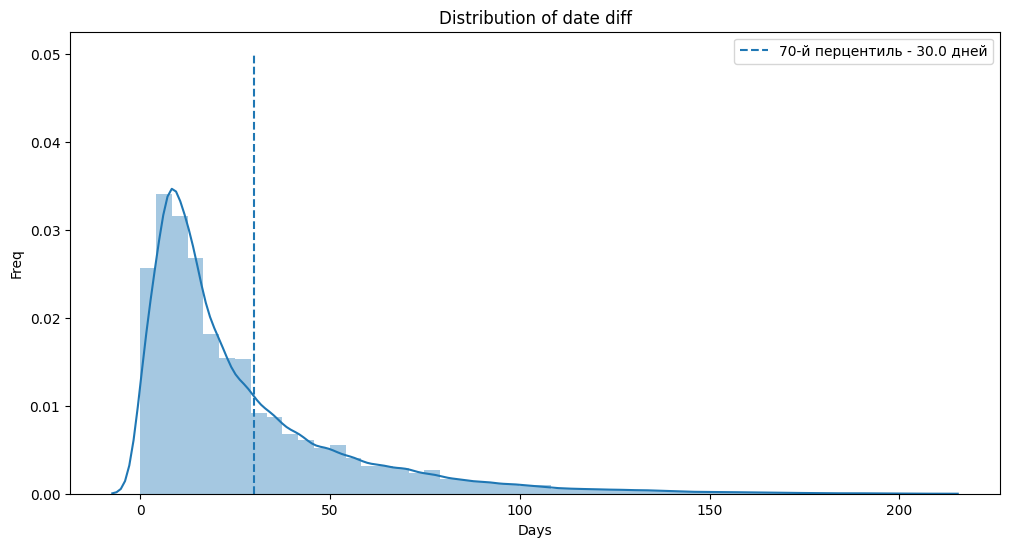

In [3]:
perc_70 = np.percentile(df.diff_day.dropna(), 70)

plt.figure(figsize=(12,6))
sns.distplot(df.diff_day.dropna())
plt.vlines(perc_70, ymax=0.05, ymin=0, linestyles='dashed', label=f'70-й перцентиль - {perc_70} дней')
plt.title('Distribution of date diff')
plt.ylabel('Freq')
plt.xlabel('Days')
plt.legend()
plt.show()

Вычисляем окно конверсии, смотрим разницу в датах и рисуем распределение, чтобы сказать, сколько времени после окончания теста нужно на дозревание (За все время, тихие заявки для будущего теста)

In [4]:
df_1 = tf.gp_to_df("""
SELECT *,
       utilization_dt - crm_income_dt AS diff_day    
FROM usr_wrk.ryunisov_nc_test_by_segments_0_1_d
""",
    gp_service='sme')

2023-08-03 15:52:41 - INFO - Query executed successfully. Result saved to DataFrame.


/var/folders/3g/twm5z59x18s28jmjj3c3ghfm0000gq/T/ipykernel_26532/295592461.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_1.diff_day.dropna())


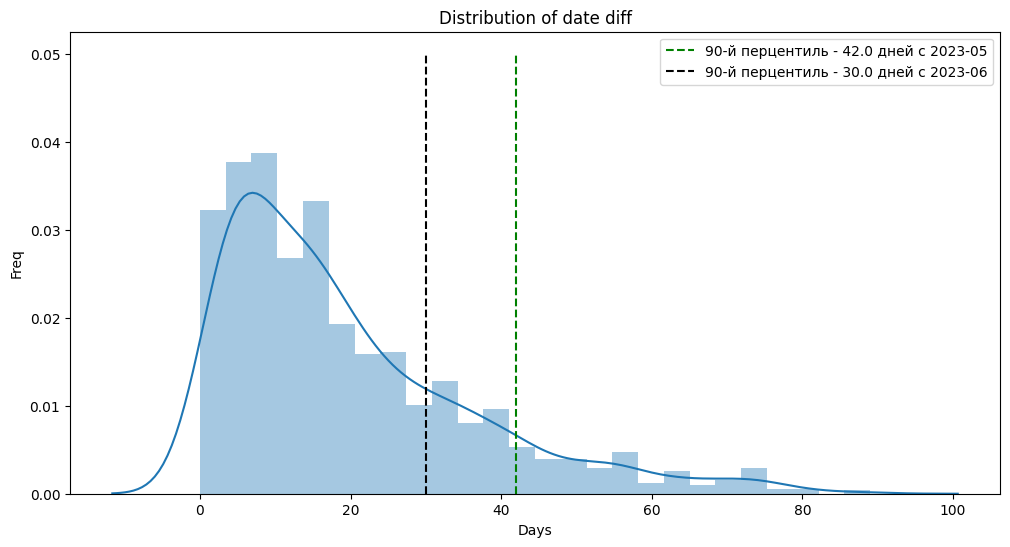

In [5]:
perc_90_2 = np.percentile(df_1.diff_day.dropna(), 90)

plt.figure(figsize=(12,6))
sns.distplot(df_1.diff_day.dropna())
plt.vlines(perc_90_2, ymax=0.05, ymin=0, linestyles='dashed', colors='green', label=f'90-й перцентиль - {perc_90_2} дней c 2023-05')
plt.vlines(30, ymax=0.05, ymin=0, linestyles='dashed', colors='black', label=f'90-й перцентиль - {30.0} дней c 2023-06')
plt.title('Distribution of date diff')
plt.ylabel('Freq')
plt.xlabel('Days')
plt.legend()
plt.show()